# GAN을 이용한 분자 생성
- GAN을 그래프로 표현된 분자 데이터에 적용하고 강화학습을 통해서 특정 속성을 가진  분자를 생성한다
 - Cao and Kipf가 제안한 MolGAN을 사용하겠다
 - MolGAN을 tox21 dataset로 학습시킨다
 - 12,060개의 훈련 샘플과 647개의 테스트 샘플 제공

- 모델은 세가지로 구성된다: generator, dicriminator, reward network

- 생성기는 정규 분포를 갖는 sample (z)로부터 그래프를 생성하며 MLP를 사용한다
 - dense adjacency tensor A (bond types)와 annotation matrix X (atom types)를 생성한다
- 판별기와 보상 네트워크는 같은 구조를 가지며 그래프를 입력으로 받는다
 - Relational GCN과 MLP를 사용하여 출력을 얻는다

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-22%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2012.10.58.png?raw=1" >

# Import

- 이전 버전의 텐서플로우 설치 필요

In [18]:
!pip install tensorflow~=2.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 65.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0

In [1]:
!pip install deepchem

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import deepchem as dc
import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
import tensorflow as tf
from tensorflow import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

# 데이터

- tox21 데이터를 다운로드하고 SMILES을 추출한다

In [3]:
tasks, datasets, transformers = dc.molnet.load_tox21()
data = pd.DataFrame(data={'smiles': datasets[0].ids})

In [4]:
datasets

(<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>,
 <DiskDataset X.shape: (783, 1024), y.shape: (783, 12), w.shape: (783, 12), ids: ['N#C[C@@H]1CC(F)(F)CN1C(=O)CNC1CC2CCC(C1)N2c1ncccn1'
  'CN(C)C(=O)NC1(c2ccccc2)CCN(CCC[C@@]2(c3ccc(Cl)c(Cl)c3)CCCN(C(=O)c3ccccc3)C2)CC1'
  'CSc1nnc(C(C)(C)C)c(=O)n1N' ...
  'O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1'
  'C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4[C@H]3C(=C)C[C@@]21CC'
  'NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3c(c2)CCO3)C1'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>,
 <DiskDataset X.shape: (784, 1024), y.shape: (784, 12), w.shape: (784, 12), ids: ['CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.c1ccc(CNCCNCc2ccccc2)cc1'
  'CC(C)(c1ccc(Oc2ccc3c(c2)C(=O)OC3=O)cc1)c1ccc(Oc2ccc3c(c2)C(=O)OC3=O)cc1'
  'Cc1cc(C(C)(C)C)c(O)c(C)c1

In [5]:
data[:5]

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C


- MolGAN 특성을 선택하면서, 최대 원자수, 원자번호 등을 제한할 수 있다
- 계산량을 줄이기 위해서 원자의 최대수를 12로 제한하겠다

In [6]:
# create featurizer
num_atoms = 12

feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms,
  atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14]) #15, 16, 17, 19, 20, 24, 29, 35, 53, 80])

In [7]:
# 원자수가 12 이상인 분자 제거
smiles = data['smiles'].values
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]
filtered_smiles[:10]

[15:38:44] WARNING: not removing hydrogen atom without neighbors


['CC(O)(P(=O)(O)O)P(=O)(O)O',
 'OC[C@H](O)[C@@H](O)[C@H](O)CO',
 'CC(C)COC(=O)C(C)C',
 'C#CCO',
 'CC(O)CC(C)(C)O',
 'CC(C)(C)CC(C)(C)N',
 'CC(=O)CC(C)C',
 'CCCC(C)=O',
 'CC/C=C\\CCCCO',
 'CC(=O)CCC(C)=O']

In [8]:
# 분자 특성화
features = feat.featurize(filtered_smiles)

[15:38:52] WARNING: not removing hydrogen atom without neighbors


In [9]:
len(features)

2081

- GraphMatrix 타입 확인

In [10]:
# 타입이 GraphMatrix인 항목만 찾는다
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ]
features = [features[i] for i in indices]

In [11]:
len(features)

1371

# 모델 구성
- deepchem이 제공하는 BasicMolGANModel 사용 (Keras 기반)

- MolGAN 모델을 만들고, learning rate와 최대 원자 갯수를 지정한다
- MolGAN의 입력에 맞도록 dataset를 준비한다

In [12]:
# 모델 생성
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000),
             vertices=num_atoms, model_dir = 'molgan')
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

- 배치단위로 읽는 함수를 정의

In [13]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

# 모델 학습

- fit_gan 함수로 모델을 학습시키고, predict_gan_generator 함수로 분자를 생성한다

In [14]:
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 349: generator average loss -5.21761, discriminator average loss -12.3631
TIMING: model fitting took 13.632 s


## 저장된 모델 가져오기

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000),
#              vertices=num_atoms, model_dir = '/content/drive/MyDrive/molgan')

# gan.restore()

# 결과 보기
- 생성된 그래프를 RDKit molecule 형태로 변환한다

In [15]:
generated_data = gan.predict_gan_generator(1000)

Generating 1000 samples


In [16]:
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


[15:40:06] Explicit valence for atom # 0 O, 33, is greater than permitted
[15:40:06] Explicit valence for atom # 0 C, 9, is greater than permitted
[15:40:06] Explicit valence for atom # 0 O, 32, is greater than permitted
[15:40:06] Explicit valence for atom # 0 B, 33, is greater than permitted
[15:40:06] Explicit valence for atom # 0 C, 26, is greater than permitted
[15:40:06] Explicit valence for atom # 0 O, 33, is greater than permitted
[15:40:06] Explicit valence for atom # 0 O, 33, is greater than permitted
[15:40:06] Explicit valence for atom # 1 O, 30, is greater than permitted
[15:40:06] Explicit valence for atom # 0 C, 22, is greater than permitted
[15:40:06] Explicit valence for atom # 0 O, 33, is greater than permitted
[15:40:06] Explicit valence for atom # 0 C, 28, is greater than permitted
[15:40:06] Explicit valence for atom # 0 B, 31, is greater than permitted
[15:40:06] Explicit valence for atom # 0 O, 33, is greater than permitted
[15:40:06] Explicit valence for atom # 

In [17]:
nmols[:10]

array([<rdkit.Chem.rdchem.Mol object at 0x7ca25cb04b30>,
       <rdkit.Chem.rdchem.Mol object at 0x7ca25cb049e0>, None, None,
       <rdkit.Chem.rdchem.Mol object at 0x7ca25cb04820>, None, None,
       <rdkit.Chem.rdchem.Mol object at 0x7ca25cb04740>], dtype=object)

In [18]:
(nmols == None).sum()

475

- 변환이 제대로 되지 않는 분자 제거

In [19]:
nmols = list(filter(lambda x: x is not None, nmols))

- 유효한 분자수를 출력한다

In [20]:
len(nmols)

525

## 중복된 분자 제거

In [21]:
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles[:20]

['CCCCNCN',
 'CCCCNCN',
 'CCCCNCN',
 'NCNCCCO',
 'CCCCNCN',
 'CCCCNCN',
 'CCCCNCN',
 'CCCCNCN',
 'NCNCCCO',
 'CCCCNCN',
 'CCCCNCN',
 'NCNCCCO',
 'CCCCNCN',
 'CCCCNCN',
 'CCCCNCN',
 'CCCCNCN',
 'CCCCNCN',
 'CCCCNCN',
 'CCCCNCN',
 'CCCCNCN']

In [22]:
OrderedDict.fromkeys(nmols_smiles)

OrderedDict([('CCCCNCN', None),
             ('NCNCCCO', None),
             ('CCC=C(C)NCCCO', None),
             ('CCNCCCO', None),
             ('CC(N)N', None),
             ('CCCNCNCCCO', None),
             ('CCCN', None)])

In [23]:
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
len(nmols_viz)

7

In [24]:
nmols_viz[:3]

## 생성된 분자 출력

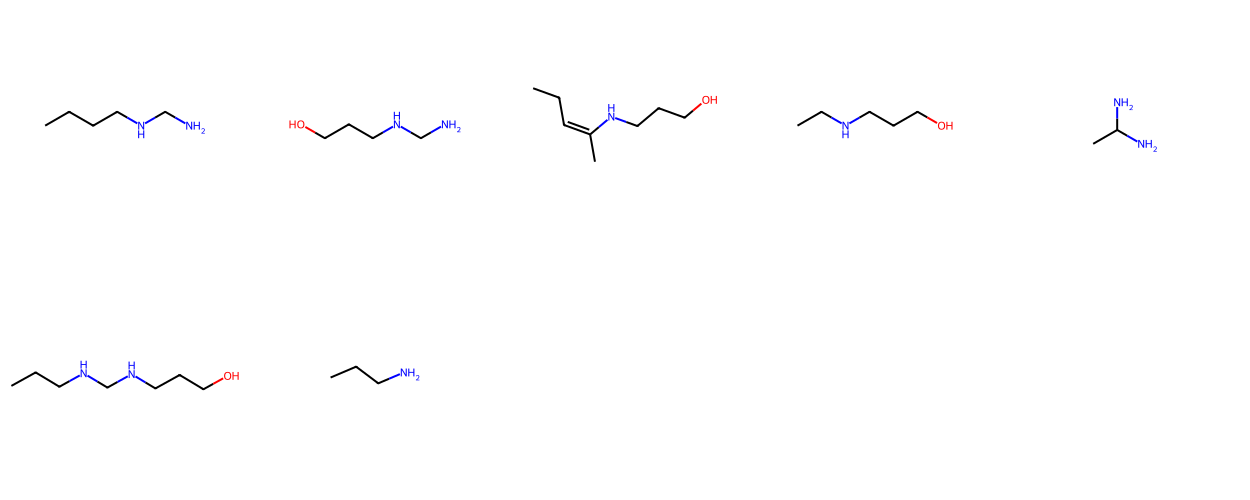

In [25]:
img = Draw.MolsToGridImage(nmols_viz, molsPerRow=5, subImgSize=(250, 250), maxMols=20, legends=None, returnPNG=False)
img